# Creating the individua modules within Jupyter

Add `--display --write_to_file` to visualize and write to the same named .py file. This will override existing files!

In [1]:
# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1
%reload_ext hamilton.plugins.jupyter_magic


In [2]:
%%cell_to_module load_data

from sklearn.datasets import fetch_species_distributions
from sklearn.utils._bunch import Bunch


def data() -> Bunch:
    return fetch_species_distributions()


In [3]:
%%cell_to_module grids

from typing import Tuple

import numpy as np
import numpy.typing as npt
from original_script import construct_grids
from sklearn.utils._bunch import Bunch

from hamilton.function_modifiers import pipe_input, step


def _construct_grids(batch: Bunch) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Our wrapper around and external function to integrate it as a node in the DAG."""
    return construct_grids(batch=batch)


@pipe_input(step(_construct_grids))
def data_grid_(
    data: Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]],
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    return data


def meshgrid(
    data_grid_: Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]],
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    return np.meshgrid(data_grid_[0], data_grid_[1][::-1])


def land_reference(data: Bunch) -> npt.NDArray[np.float64]:
    return data.coverages[6]


def idx(land_reference: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return np.where(land_reference > -9999)


def coverages_land(data: Bunch, idx: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return data.coverages[:, idx[0], idx[1]].T


def background_points(data: Bunch) -> npt.NDArray[np.float64]:
    np.random.seed(13)
    return np.c_[
        np.random.randint(low=0, high=data.Ny, size=10000),
        np.random.randint(low=0, high=data.Nx, size=10000),
    ].T


In [4]:
%%cell_to_module preprocessing

from typing import Dict, Tuple

import numpy as np
import numpy.typing as npt
from original_script import create_species_bunch
from sklearn.utils._bunch import Bunch

from hamilton.function_modifiers import extract_fields, pipe_input, source, step


def _create_species_bunch(
    species_name: str,
    _data: Bunch,
    _data_grid: Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]],
) -> npt.NDArray[np.float64]:
    """Our wrapper around and external function to integrate it as a node in the DAG."""
    return create_species_bunch(
        species_name, _data.train, _data.test, _data.coverages, _data_grid[0], _data_grid[1]
    )


def _standardize_features(
    species_bunch: npt.NDArray[np.float64],
) -> Tuple[
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
]:
    mean = species_bunch.cov_train.mean(axis=0)
    std = species_bunch.cov_train.std(axis=0)
    return species_bunch, mean, std


@extract_fields(
    {
        "bunch": Bunch,
        "mean": npt.NDArray[np.float64],
        "std": npt.NDArray[np.float64],
        "train_cover_std": npt.NDArray[np.float64],
        "test_cover_std": npt.NDArray[np.float64],
    }
)
@pipe_input(
    step(_create_species_bunch, _data=source("data"), _data_grid=source("data_grid_")),
    step(_standardize_features),
)
def species(
    chosen_species: Tuple[
        npt.NDArray[np.float64],
        npt.NDArray[np.float64],
        npt.NDArray[np.float64],
    ],
) -> Dict[str, npt.NDArray[np.float64]]:
    train_cover_std = (chosen_species[0].cov_train - chosen_species[1]) / chosen_species[2]
    return {
        "bunch": chosen_species[0],
        "mean": chosen_species[1],
        "std": chosen_species[2],
        "train_cover_std": train_cover_std,
        "test_cover_std": chosen_species[0].cov_test,
    }

In [5]:
%%cell_to_module train_and_predict

import numpy as np
import numpy.typing as npt
from sklearn import svm
from sklearn.utils._bunch import Bunch

from hamilton.function_modifiers import pipe_output, source, step, value


# TODO: add another model or two and use `.when` to showcase that this can be customizable @execution
def _OneClassSVM_model(
    training_set: npt.NDArray[np.float64], nu: float, kernel: str, gamma: float
) -> svm.OneClassSVM:
    clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
    clf.fit(training_set)
    return clf


def _decision_function(
    model: svm.OneClassSVM,
    underlying_data: npt.NDArray[np.float64],
    _mean: npt.NDArray[np.float64],
    _std: npt.NDArray[np.float64],
) -> npt.NDArray[np.float64]:
    return model.decision_function((underlying_data - _mean) / _std)


def _prediction_step(
    decision: npt.NDArray[np.float64], _idx: npt.NDArray[np.float64], _data: Bunch
) -> npt.NDArray[np.float64]:
    Z = decision.min() * np.ones((_data.Ny, _data.Nx), dtype=np.float64)
    Z[_idx[0], _idx[1]] = decision
    return Z


@pipe_output(
    step(_OneClassSVM_model, nu=value(0.1), kernel=value("rbf"), gamma=value(0.5)),
    step(
        _decision_function,
        underlying_data=source("coverages_land"),
        _mean=source("mean"),
        _std=source("std"),
    ),
    step(_prediction_step, _idx=source("idx"), _data=source("data")),
)
def prediction_train(train_cover_std: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return train_cover_std


@pipe_output(
    step(_OneClassSVM_model, nu=value(0.1), kernel=value("rbf"), gamma=value(0.5)),
    step(
        _decision_function,
        underlying_data=source("test_cover_std"),
        _mean=source("mean"),
        _std=source("std"),
    ),
)
def prediction_test(train_cover_std: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return train_cover_std


In [6]:
%%cell_to_module postprocessing_results

from typing import Any, Dict, Tuple

import numpy as np
import numpy.typing as npt
from sklearn import metrics
from sklearn.utils._bunch import Bunch

from hamilton.function_modifiers import pipe_input, source, step


def _normalize(
    _data: npt.NDArray[np.float64], _land_reference: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    _data[_land_reference == -9999] = -9999
    return _data


@pipe_input(step(_normalize, _land_reference=source("land_reference")))
def prediction_background(
    prediction_train: npt.NDArray[np.float64], background_points: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    return prediction_train[background_points[0], background_points[1]]


def levels(prediction_train: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return np.linspace(prediction_train.min(), prediction_train.max(), 25)


def area_under_curve(
    prediction_test: npt.NDArray[np.float64],
    prediction_background: npt.NDArray[np.float64],
) -> float:
    scores = np.r_[prediction_test, prediction_background]
    y = np.r_[np.ones(prediction_test.shape), np.zeros(prediction_background.shape)]
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


def plot_species_distribution(
    meshgrid: Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]],
    prediction_train: npt.NDArray[np.float64],
    land_reference: npt.NDArray[np.float64],
    levels: npt.NDArray[np.float64],
    bunch: Bunch,
    area_under_curve: float,
) -> Dict[str, Any]:
    return {
        "X": meshgrid[0],
        "Y": meshgrid[1],
        "Z": prediction_train,
        "land_reference": land_reference,
        "levels": levels,
        "species": bunch,
        "roc_auc": area_under_curve,
    }

# Execute from here onwards to see results

## We build the DAG and can visualize it

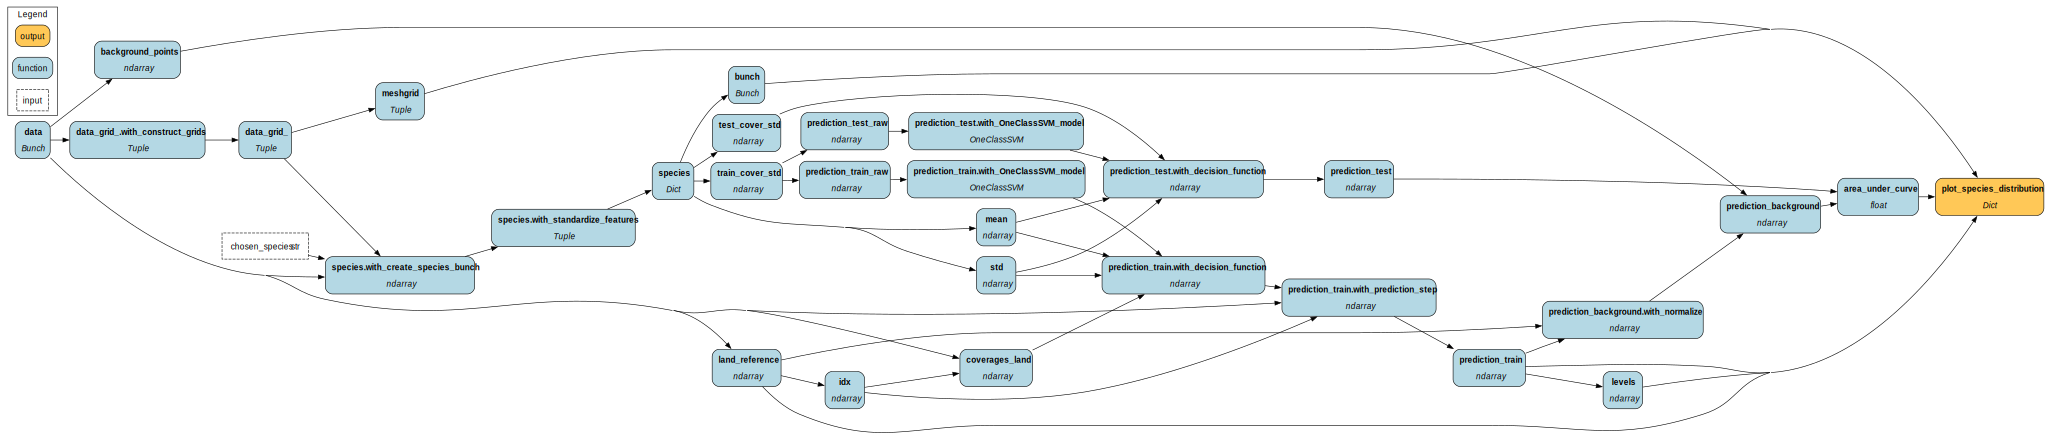

In [7]:
from hamilton import driver
import grids, load_data, postprocessing_results, preprocessing, train_and_predict

dr = driver.Builder().with_modules(grids, load_data, postprocessing_results, preprocessing, train_and_predict).build()
dr.visualize_execution(inputs={"chosen_species": "aaa"}, final_vars = ["plot_species_distribution"])

## Executing the driver and requesting the desired nodes

________________________________________________________________________________
Modeling distribution of species 'bradypus_variegatus_0'

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys_minutus_0'

 Area under the ROC curve : 0.993919


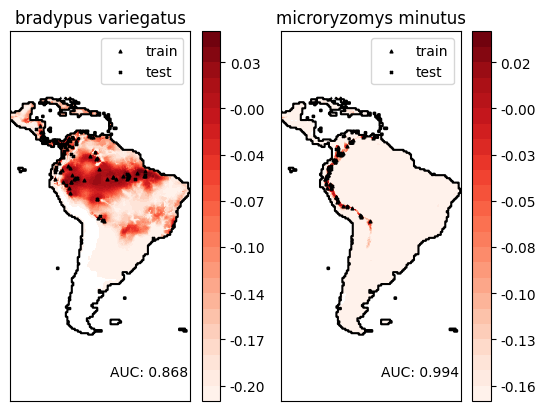

In [8]:
import matplotlib.pyplot as plt
from run import plot_helper

species=("bradypus_variegatus_0", "microryzomys_minutus_0")
for i, name in enumerate(species):
    print("_" * 80)
    print("Modeling distribution of species '%s'" % name)
    inputs = {"chosen_species": name}
    final_vars = ["plot_species_distribution"]
    results = dr.execute(inputs=inputs,final_vars=final_vars)[final_vars[0]]
    plot_helper(i=i,**results)
    
plt.show()
